In [17]:
# %% minimal bootstrap
import sys, os, subprocess, importlib.util
from pathlib import Path

def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(50):
        if any((p / m).exists() for m in ("pyproject.toml", ".git", "defaults.yaml")):
            return p
        if p == p.parent: break
        p = p.parent
    return start.resolve()

_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    spec = importlib.util.find_spec(pkg_name)
    need = (not spec) or (not getattr(spec, "origin", None)) or (Path(spec.origin).resolve().parents[0] != pkg_dir.resolve())
    if need:
        print(f"Installing {pkg_name} in editable mode from {pkg_dir} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(pkg_dir)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

diffinst already installed from this repo.


In [18]:
# %% imports & paths
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k
from diffinst.analysis_api import (
    load_manifest, load_config_from_run, list_checkpoints, load_metrics,
    load_linear_run, load_linear_Sigma_series, load_linear_amplitude,
    load_nonlinear_run, load_nonlinear_Sigma_series, load_nonlinear_amplitude,
    nearest_k_index, save_ic_npz, evp_gamma
)

EXP_STABLE   = ROOT / "experiments" / "baseline.yaml"
EXP_UNSTABLE = ROOT / "experiments" / "unstable_baseline.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

print("project root:", ROOT)

project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


In [19]:
# %% build a clean eigenmode IC once
IC_OUT  = RUNS / "ic_k100_eigen.npz"
k_phys  = 100.0
amp_phys = 1e-6

cfg_ic = Config.from_yaml(EXP_UNSTABLE, DEFAULTS)
Nx, Lx = int(cfg_ic.Nx), float(cfg_ic.Lx)
x = np.linspace(-0.5*Lx, 0.5*Lx, Nx, endpoint=False)
S0 = float(getattr(cfg_ic, "S0", getattr(cfg_ic, "sig_0", 1.0)))

w, V = evp_solve_at_k(cfg_ic, k_phys)
v = V[:, 0]
phase = 0.0
eikx = np.exp(1j*(k_phys*(x - x.min()) + phase))

S_raw, vx_raw, vy_raw, uy_raw = (v[0]*eikx).real, (v[1]*eikx).real, (v[2]*eikx).real, (v[3]*eikx).real
scale = amp_phys / max(np.max(np.abs(S_raw)), 1e-30)

Sigma0 = S0 + scale*S_raw
vx0, vy0, uy0 = scale*vx_raw, scale*vy_raw, scale*uy_raw

save_ic_npz(IC_OUT, Sigma0, vx0, vy0, uy0, meta={"k_phys": k_phys, "amp_phys": amp_phys})
print("IC written:", IC_OUT)

IC written: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/ic_k100_eigen.npz


In [26]:
# %% run linear TD from that exact IC (CLI)
! python -m scripts.run_linear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/lin_from_ic \
  --mode linear \
  --dt 1e-3 \
  --stop_time 5 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen.npz

[linear] done: {'t_final': 5.0, 'steps': 5000, 'Nx': 128, 'Lx': 0.12566370614359174}
Abort(811174927): Fatal error in internal_Finalize: Other MPI error, error stack:
internal_Finalize(50)............: MPI_Finalize failed
MPII_Finalize(441)...............: 
MPID_Finalize(804)...............: 
MPIDI_OFI_mpi_finalize_hook(1075): 
flush_send_queue(1024)...........: 
flush_send(970)..................: OFI call tsenddata failed (default nic=en0: No such file or directory)


In [27]:
# %% run nonlinear TD from that exact IC (CLI)
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_from_ic \
  --mode nonlinear \
  --dt 1e-3 \
  --stop_time 5 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen.npz

[nonlinear] done: {'t_final': 5.0, 'steps': 5000, 'Nx': 128, 'Lx': 0.12566370614359174}
Abort(811174927): Fatal error in internal_Finalize: Other MPI error, error stack:
internal_Finalize(50)............: MPI_Finalize failed
MPII_Finalize(441)...............: 
MPID_Finalize(804)...............: 
MPIDI_OFI_mpi_finalize_hook(1075): 
flush_send_queue(1024)...........: 
flush_send(970)..................: OFI call tsenddata failed (default nic=en0: No such file or directory)


In [13]:
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_from_ic_dedalus \
  --backend dedalus \
  --mode nonlinear --dt 1e-4 --stop_time 2 --save-stride 200 \
  --init-from runs/ic_k100_eigen.npz

2025-11-11 16:56:08,979 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 7.6e+01/s
2025-11-11 16:56:09,050 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 8.3e+01/s
2025-11-11 16:56:09,132 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 8.4e+01/s
2025-11-11 16:56:09,215 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 8.4e+01/s
2025-11-11 16:56:09,298 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+01/s
2025-11-11 16:56:09,380 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+01/s
2025-11-11 16:56:09,464 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+01/s
2025-11-11 16:56:09,546 subsystems 0/1 INFO :: Building subproblem matri

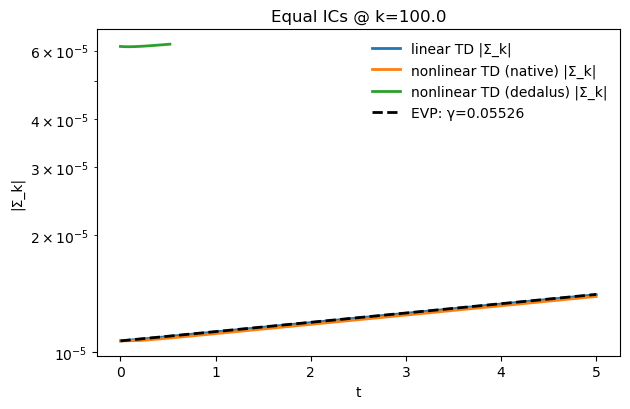

In [23]:
# %% load amplitude vs time for linear, native nonlinear, and dedalus nonlinear
RUN_L = RUNS / "lin_from_ic"
RUN_N = RUNS / "nl_from_ic"             # native
RUN_D = RUNS / "nl_from_ic_dedalus"     # dedalus

TL, AL = load_linear_amplitude(RUN_L, k_phys)
TN, AN = load_nonlinear_amplitude(RUN_N, k_phys)
TD, AD = load_nonlinear_amplitude(RUN_D, k_phys)  # <-- same call

cfgL = load_config_from_run(RUN_L)
gamma = evp_gamma(cfgL, k_phys)
A0 = AL[0]

fig, ax = plt.subplots(figsize=(6.4,4.2))
ax.plot(TL, AL, lw=2, label="linear TD |Σ_k|")
ax.plot(TN, AN, lw=2, label="nonlinear TD (native) |Σ_k|")
ax.plot(TD, AD, lw=2, label="nonlinear TD (dedalus) |Σ_k|")
ax.plot(TL, A0*np.exp(gamma*(TL - TL[0])), "k--", lw=2, label=f"EVP: γ={gamma:.4g}")
ax.set_yscale("log"); ax.set_xlabel("t"); ax.set_ylabel("|Σ_k|")
ax.legend(frameon=False); ax.set_title(f"Equal ICs @ k={k_phys}")
plt.tight_layout(); plt.show()

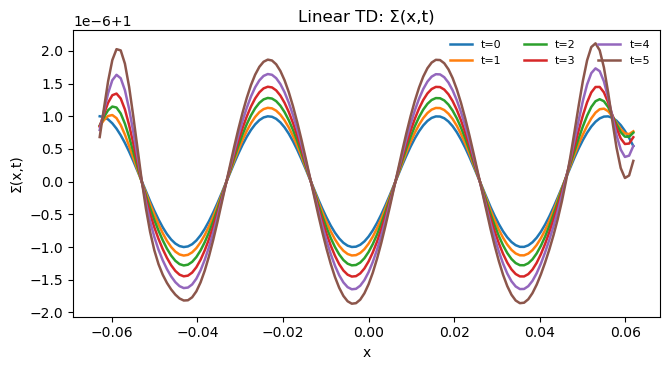

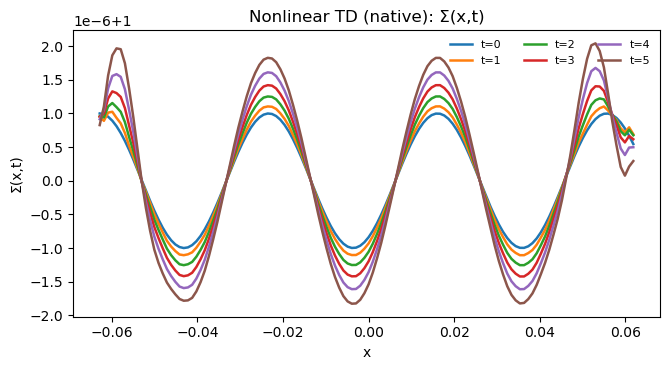

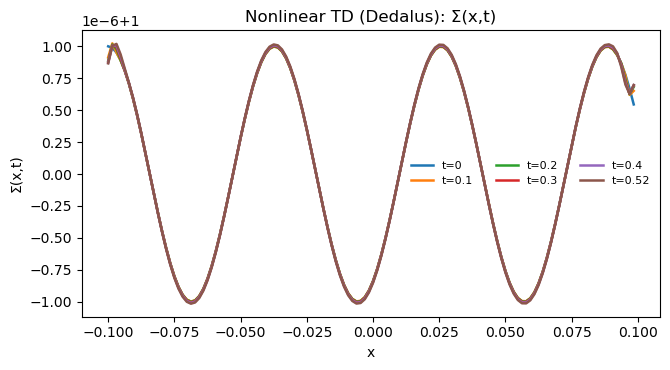

In [28]:
# %% (optional) quick Σ(x,t) snapshot panel from all three runs (linear, native NL, dedalus NL)

# linear: reconstruct Σ from spectral checkpoints; nonlinear: Σ is stored directly
NxL, LxL, filesL, *_ = load_linear_run(RUN_L)
cfgL = load_config_from_run(RUN_L); S0L = cfgL.sig_0
TLs, SigL = load_linear_Sigma_series(filesL, NxL, S0L)

NxN, LxN, filesN, _ = load_nonlinear_run(RUN_N)         # native nonlinear
TNs, SigN = load_nonlinear_Sigma_series(filesN)

# --- NEW: Dedalus nonlinear ---
NxD, LxD, filesD, _ = load_nonlinear_run(RUN_D)          # dedalus nonlinear (same format)
TDs, SigD = load_nonlinear_Sigma_series(filesD)

def plot_snapshots(x, T, Sig, title, nsamp=6):
    import matplotlib.pyplot as plt
    idxs = np.linspace(0, len(T)-1, nsamp, dtype=int)
    fig, ax = plt.subplots(figsize=(6.8,3.8))
    for j, i in enumerate(idxs):
        ax.plot(x, Sig[i], lw=1.8, label=f"t={T[i]:.3g}")
    ax.set_xlabel("x"); ax.set_ylabel("Σ(x,t)")
    ax.set_title(title); ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

xL = np.linspace(-0.5*LxL, 0.5*LxL, NxL, endpoint=False)
xN = np.linspace(-0.5*LxN, 0.5*LxN, NxN, endpoint=False)
xD = np.linspace(-0.5*LxD, 0.5*LxD, NxD, endpoint=False)

plot_snapshots(xL, TLs, SigL, "Linear TD: Σ(x,t)")
plot_snapshots(xN, TNs, SigN, "Nonlinear TD (native): Σ(x,t)")
plot_snapshots(xD, TDs, SigD, "Nonlinear TD (Dedalus): Σ(x,t)")

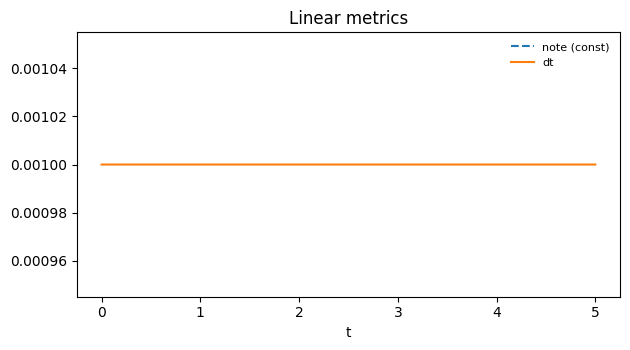

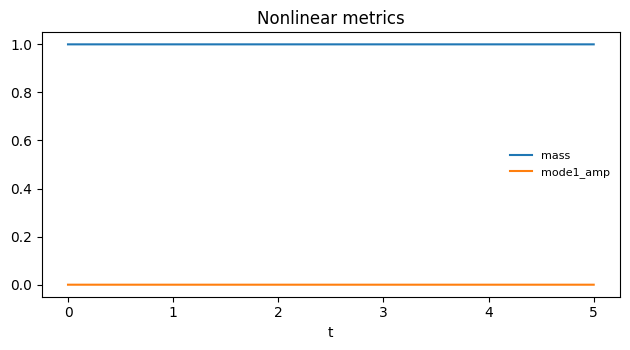

In [8]:
# %% (optional) inspect tracked metrics if present — robust version
tM_L, colsL = load_metrics(RUN_L)
tM_N, colsN = load_metrics(RUN_N)

import numpy as np
import matplotlib.pyplot as plt

def quick_metrics(t, cols, title):
    if t is None or np.size(t) == 0 or not cols:
        print(f"{title}: no metrics found.")
        return
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    plotted = False
    for k, v in cols.items():
        a = np.asarray(v).squeeze()
        if a.size == 0:
            continue
        if a.size == 1:
            # scalar/length-1 → draw horizontal line across full t
            ax.plot(t, np.full_like(t, float(a), dtype=float), linestyle="--", label=f"{k} (const)")
            plotted = True
        else:
            n = min(len(t), len(a))
            ax.plot(t[:n], a[:n], label=k)
            plotted = True
    if not plotted:
        print(f"{title}: nothing plottable (only empty/scalars).")
        plt.close(fig)
        return
    ax.set_xlabel("t")
    ax.legend(frameon=False, fontsize=8)
    ax.set_title(title)
    plt.tight_layout(); plt.show()

quick_metrics(tM_L, colsL, "Linear metrics")
quick_metrics(tM_N, colsN, "Nonlinear metrics")

In [10]:
# %% Recover linear operator from RHS at k via small complex sinusoid
from diffinst.linear_ops import L_of_k
from diffinst.nonlinear_terms import rhs
from diffinst.operators import PSOperators

def rhs_symbol_from_nonlinear(cfg, k_phys, Nx=None, Lx=None, eps_amp=1e-8):
    """
    Build the 4x4 symbol M_nl(k) so that d/dt [S, vx, vy, uy]^T ≈ M_nl(k) [S, vx, vy, uy]^T
    by probing the nonlinear RHS with small complex plane waves at wavenumber k_phys.
    """
    # domain
    Nx = int(Nx if Nx is not None else cfg.Nx)
    Lx = float(Lx if Lx is not None else cfg.Lx)
    x  = np.linspace(-0.5*Lx, 0.5*Lx, Nx, endpoint=False)
    ops = PSOperators(nx=Nx, Lx=Lx, dealias=False)

    # base state (uniform)
    S0   = float(getattr(cfg, "S0", getattr(cfg, "sig_0", 1.0)))
    vx0  = np.zeros(Nx); vy0 = np.zeros(Nx); uy0 = np.zeros(Nx)
    base = {"Sigma": S0*np.ones(Nx), "vx": vx0, "vy": vy0, "uy": uy0}

    # params dict used by nonlinear_terms
    params = dict(
        D0=float(getattr(cfg, "D0", getattr(cfg, "D_0", 0.0))),
        beta_diff=float(getattr(cfg, "beta_diff", 0.0)),
        nu0=float(getattr(cfg, "nu0", getattr(cfg, "nu_0", 0.0))),
        beta_visc=float(getattr(cfg, "beta_visc", 0.0)),
        S0=S0,
        Omega=float(getattr(cfg, "Omega", 0.0)),
        q=float(getattr(cfg, "q", 1.5)),
        ts=float(getattr(cfg, "ts", 1.0)),
        eps=float(getattr(cfg, "eps", getattr(cfg, "epsilon", 0.0))),
        nu_g=float(getattr(cfg, "nu_g", 0.0)),
    )

    # complex plane wave
    eikx = np.exp(1j * k_phys * (x - x.min()))
    M = np.zeros((4,4), dtype=complex)

    # probe columns: add one variable = eps * Re(e^{ikx}), measure response, project back onto e^{ikx}
    cols = [
        ("Sigma",), ("vx",), ("vy",), ("uy",)
    ]
    for j, (name,) in enumerate(cols):
        pert = {k: np.zeros(Nx, dtype=float) for k in base.keys()}
        # use real part; projection will pick out the k component (imag parts are handled in complex fit)
        pert[name] = eps_amp * eikx.real

        st = {k: (base[k] + pert[k]) for k in base.keys()}
        dr = rhs(st, params, ops)  # dictionary with time derivatives

        # project each derivative back onto e^{ikx} to get the k-mode coefficient
        for i, key in enumerate(["Sigma","vx","vy","uy"]):
            # inner product with cos and sin to reconstruct complex amp at k
            y = dr[key]
            # compute complex coefficient of e^{ikx}: use FFT at the matching k-bin
            # find k index that matches k_phys on this grid
            ks = 2.0*np.pi*np.fft.rfftfreq(Nx, d=Lx/Nx)
            ik = int(np.argmin(np.abs(ks - k_phys)))
            Yk = np.fft.rfft(y)[ik]
            Xk = np.fft.rfft(pert[name])[ik]
            #M[i, j] = (Yk / (Xk + 0j))  # derivative per unit amplitude at that k
            M[i, j] = (Yk / (Xk + 0j)).conj()

    return M

# Quick compare helper
def compare_symbols(cfg, k_phys, Nx=None, Lx=None):
    M_nl = rhs_symbol_from_nonlinear(cfg, k_phys, Nx=Nx, Lx=Lx)
    M_ev = L_of_k(cfg, float(k_phys))
    err = np.abs(M_nl - M_ev)
    rel = err / (np.maximum(1e-14, np.abs(M_ev)))
    return M_nl, M_ev, err, rel

# Example: run at your k_phys with the same domain as the runs
k_test = float(k_phys)
M_nl, M_ev, err, rel = compare_symbols(cfgL, k_test, Nx=NxN, Lx=LxN)
print("max abs err:", np.max(err))
print("max rel err:", np.max(rel))
print("per-entry rel err:\n", np.array_str(rel, precision=3, suppress_small=True))

max abs err: 8.006040275190568e-12
max rel err: 1.0975306311926378e-09
per-entry rel err:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
